In [1]:
import re
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
plt.style.use('ggplot')
%matplotlib inline
pd.set_option('display.max_rows', 400) # показывать больше строк
pd.set_option('display.max_columns', 30) # по

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

    Restaurant_id — идентификационный номер ресторана / сети ресторанов;
    City — город, в котором находится ресторан;
    Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
    Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
    Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
    Price Range — диапазон цен в ресторане;
    Number of Reviews — количество отзывов о ресторане;
    Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
    URL_TA — URL страницы ресторана на TripAdvosor;
    ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [4]:
DATA_DIR = '.'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


приводим названия колонок к одному виду

все виды кухонь мы переносим в другую таблицу, что бы не пересобирать их при каждом прогоне, позднее эти таблицы будут соединены

все что ниже в кавычках - в citchens.ipynb и таблице citchens.csv

In [8]:
'''def str_to_arr(string):
    if pd.isna(string):
        return
    arr = []
    arr_temp = np.array([])
    if string[0] == '[' and string[-1] == ']':
        string = string[1:-1]
        arr_temp = np.array(string.split(', '))
    for a in arr_temp:
        a = a.replace("'", '')
        arr.append(a)
    arr = np.array(arr)
    return arr
df['Cuisine Style'] = df['Cuisine Style'].apply(str_to_arr)'''

'def str_to_arr(string):\n    if pd.isna(string):\n        return\n    arr = []\n    arr_temp = np.array([])\n    if string[0] == \'[\' and string[-1] == \']\':\n        string = string[1:-1]\n        arr_temp = np.array(string.split(\', \'))\n    for a in arr_temp:\n        a = a.replace("\'", \'\')\n        arr.append(a)\n    arr = np.array(arr)\n    return arr\ndf[\'Cuisine Style\'] = df[\'Cuisine Style\'].apply(str_to_arr)'

In [9]:
'''df['Cuisine Style'] = df['Cuisine Style'].fillna('n')'''

"df['Cuisine Style'] = df['Cuisine Style'].fillna('n')"

In [10]:
'''citchen_wariable_arr = []
def citchen_wariable(arr):
    for i in arr:
        if i != 'n':
            if i not in citchen_wariable_arr:
                citchen_wariable_arr.append(i)
                
df['Cuisine Style'].apply(citchen_wariable)
citchen_wariable_arr.sort()
citchen_wariable_arr_new = []
for i in citchen_wariable_arr:
    i = 'citchen_{0}'.format(i.replace(' ', '_'))
    citchen_wariable_arr_new.append(i)
len(citchen_wariable_arr)'''

"citchen_wariable_arr = []\ndef citchen_wariable(arr):\n    for i in arr:\n        if i != 'n':\n            if i not in citchen_wariable_arr:\n                citchen_wariable_arr.append(i)\n                \ndf['Cuisine Style'].apply(citchen_wariable)\ncitchen_wariable_arr.sort()\ncitchen_wariable_arr_new = []\nfor i in citchen_wariable_arr:\n    i = 'citchen_{0}'.format(i.replace(' ', '_'))\n    citchen_wariable_arr_new.append(i)\nlen(citchen_wariable_arr)"

In [11]:
"""citchens =  pd.DataFrame(np.zeros(shape=(len(df), len(citchen_wariable_arr))), columns=citchen_wariable_arr_new)
"""

'citchens =  pd.DataFrame(np.zeros(shape=(len(df), len(citchen_wariable_arr))), columns=citchen_wariable_arr_new)\n'

In [12]:
"""for i in df.index:
    citchen = df.loc[i]['Cuisine Style']
    if type(citchen) != 'str':
        for j in citchen:
            j = j.replace(' ', '_')
            citchens.loc[i, 'citchen_{0}'.format(j)] = 1
            
citchens.citchen_n.fillna(0)"""

"for i in df.index:\n    citchen = df.loc[i]['Cuisine Style']\n    if type(citchen) != 'str':\n        for j in citchen:\n            j = j.replace(' ', '_')\n            citchens.loc[i, 'citchen_{0}'.format(j)] = 1\n            \ncitchens.citchen_n.fillna(0)"

In [13]:
"""citchens.to_csv('citchens.csv')"""

"citchens.to_csv('citchens.csv')"

In [14]:
"""citchens.info()"""

'citchens.info()'

In [15]:
citchens = pd.read_csv('./citchens.csv')
citchens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 127 entries, Unnamed: 0 to citchen_n
dtypes: float64(126), int64(1)
memory usage: 48.4 MB


count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: Ranking, dtype: float64

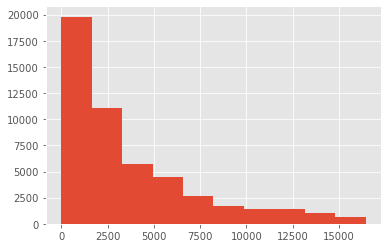

In [16]:
df['Ranking'].hist()
df['Ranking'].describe()


count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object

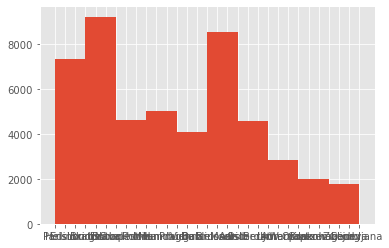

In [17]:
df['City'].hist()
df['City'].describe()

In [18]:
df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   Cuisine Style      38410 non-null  object 
 2   Ranking            50000 non-null  float64
 3   Price Range        32639 non-null  object 
 4   Number of Reviews  46800 non-null  float64
 5   Reviews            49998 non-null  object 
 6   URL_TA             50000 non-null  object 
 7   ID_TA              50000 non-null  object 
 8   sample             50000 non-null  int64  
 9   Rating             50000 non-null  float64
 10  City_Amsterdam     50000 non-null  uint8  
 11  City_Athens        50000 non-null  uint8  
 12  City_Barcelona     50000 non-null  uint8  
 13  City_Berlin        50000 non-null  uint8  
 14  City_Bratislava    50000 non-null  uint8  
 15  City_Brussels      50000 non-null  uint8  
 16  City_Budapest      500

In [20]:
df['Price Range'].describe()

count        32639
unique           3
top       $$ - $$$
freq         23041
Name: Price Range, dtype: object

In [21]:
df['Price Range'] = df['Price Range'].fillna(df['Price Range'].mode()[0])

In [22]:
price_range = {'$$ - $$$' : 1, '$': 0, '$$$$':2}
df['Price Range'] = df['Price Range'].map(price_range)
df = pd.get_dummies(df, columns=['Price Range',], dummy_na=True)

In [23]:
df['Price Range_nan'].unique()

array([0], dtype=uint8)

In [24]:
df = df.drop('Price Range_nan', axis = 1)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   Cuisine Style      38410 non-null  object 
 2   Ranking            50000 non-null  float64
 3   Number of Reviews  46800 non-null  float64
 4   Reviews            49998 non-null  object 
 5   URL_TA             50000 non-null  object 
 6   ID_TA              50000 non-null  object 
 7   sample             50000 non-null  int64  
 8   Rating             50000 non-null  float64
 9   City_Amsterdam     50000 non-null  uint8  
 10  City_Athens        50000 non-null  uint8  
 11  City_Barcelona     50000 non-null  uint8  
 12  City_Berlin        50000 non-null  uint8  
 13  City_Bratislava    50000 non-null  uint8  
 14  City_Brussels      50000 non-null  uint8  
 15  City_Budapest      50000 non-null  uint8  
 16  City_Copenhagen    500

In [26]:
df = df.drop('City_nan', axis = 1)

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

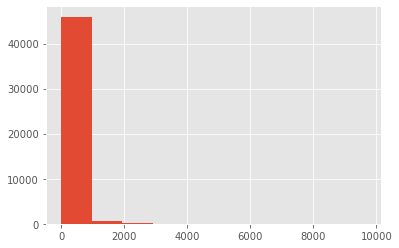

In [27]:
df['Number of Reviews'].hist()
df['Number of Reviews'].describe()

In [28]:
df['Number of Reviews'] = df['Number of Reviews'].fillna(0)

In [29]:
df['Number of Reviews'].value_counts().sort_index()

0.0       3200
2.0       2403
3.0       2042
4.0       1707
5.0       1471
          ... 
6777.0       1
7575.0       1
7622.0       1
8927.0       1
9660.0       1
Name: Number of Reviews, Length: 1574, dtype: int64

In [30]:
df['Reviews'].describe()

count        49998
unique       41857
top       [[], []]
freq          8112
Name: Reviews, dtype: object

In [31]:
df['Reviews'][:10]

0                                             [[], []]
1    [['Very good reviews!', 'Fine dining in Hakani...
2    [['Better than the Links', 'Ivy Black'], ['12/...
3    [['Most exquisite', 'Delicious and authentic']...
4    [['Always the best in bratislava', 'Very good ...
5    [['Lunch Break', 'Good to Quick Bite'], ['09/0...
6                                             [[], []]
7                                             [[], []]
8    [['Big group supper', 'Good food but very slow...
9    [['Good food', 'Good pizza'], ['12/02/2017', '...
Name: Reviews, dtype: object

In [35]:
citchens = pd.read_csv('./citchens.csv', index)

In [39]:
citchens['Unnamed: 0']

0            0
1            1
2            2
3            3
4            4
         ...  
49995    49995
49996    49996
49997    49997
49998    49998
49999    49999
Name: Unnamed: 0, Length: 50000, dtype: int64

In [40]:
fin_df = df.merge(citchens, left_index=True, right_index=True)

In [41]:
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 170 entries, Restaurant_id to citchen_n
dtypes: float64(129), int64(2), object(5), uint8(34)
memory usage: 53.5+ MB


In [42]:
fin_df.corr()

,Ranking,Number of Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,...,citchen_Thai,citchen_Tibetan,citchen_Tunisian,citchen_Turkish,citchen_Ukrainian,citchen_Uzbek,citchen_Vegan_Options,citchen_Vegetarian_Friendly,citchen_Venezuelan,citchen_Vietnamese,citchen_Welsh,citchen_Wine_Bar,citchen_Xinjiang,citchen_Yunnan,citchen_n
Ranking,1.000000,-0.223198,6.270720e-03,-0.109897,-0.094100,-0.094479,0.015683,-0.026436,-0.075731,-0.094241,-0.095421,-0.093549,-0.094884,-9.238038e-02,-0.087158,...,-0.000618,-0.008947,0.006545,0.016448,-0.006160,-0.002653,-0.216514,-0.299214,-0.007989,-0.009851,-0.005372,-0.041328,0.003277,-0.004805,0.150058
Number of Reviews,-0.223198,1.000000,2.688330e-03,0.011006,0.014532,-0.012802,0.009418,-0.049192,-0.022211,-0.017096,0.014535,-0.011974,0.013848,4.921025e-02,-0.022437,...,-0.004096,0.000947,-0.003336,-0.019254,-0.004219,-0.001625,0.323254,0.366176,-0.002710,-0.015490,0.002413,0.008331,-0.001180,0.001127,-0.201584
sample,0.006271,0.002688,1.000000e+00,0.936543,-0.003550,0.002912,0.003577,-0.001989,-0.001727,0.002751,-0.000283,0.001497,0.001638,-3.469977e-17,0.004167,...,0.001709,0.001661,0.006063,-0.007134,0.005001,0.005000,-0.009640,-0.003094,-0.001253,0.006947,-0.002582,-0.001752,0.002236,-0.004744,0.001303
Rating,-0.109897,0.011006,9.365435e-01,1.000000,0.007447,0.016852,-0.000703,0.012834,-0.002550,-0.003957,0.006301,0.000948,0.005758,5.483508e-03,0.002312,...,0.002007,0.003829,0.005758,-0.002158,0.007983,0.008242,0.029015,0.037317,-0.000704,0.013444,-0.000883,0.017776,0.002112,-0.004430,-0.010781
City_Amsterdam,-0.094100,0.014532,-3.550404e-03,0.007447,1.000000,-0.021090,-0.045335,-0.040171,-0.014699,-0.027595,-0.024252,-0.021676,-0.021903,-2.065793e-02,-0.018355,...,0.001522,0.016294,-0.003603,0.015227,-0.003360,-0.001680,0.029325,0.055126,-0.005367,-0.006702,-0.001301,-0.015915,-0.000751,-0.001062,-0.033663
City_Athens,-0.094479,-0.012802,2.912415e-03,0.016852,-0.021090,1.000000,-0.033888,-0.030027,-0.010988,-0.020627,-0.018128,-0.016203,-0.016373,-1.544171e-02,-0.013720,...,-0.010007,-0.003025,-0.002694,-0.004418,-0.002512,-0.001256,0.021809,-0.011024,-0.004012,-0.014092,-0.000973,0.009107,-0.000562,-0.000794,-0.011839
City_Barcelona,0.015683,0.009418,3.577473e-03,-0.000703,-0.045335,-0.033888,1.000000,-0.064548,-0.023619,-0.044340,-0.038968,-0.034829,-0.035195,-3.319377e-02,-0.029493,...,-0.026974,-0.003200,-0.005790,-0.018638,-0.005399,0.005251,0.019299,-0.010977,0.016281,-0.025989,-0.002091,-0.006388,-0.001207,0.010863,0.000007
City_Berlin,-0.026436,-0.049192,-1.989259e-03,0.012834,-0.040171,-0.030027,-0.064548,1.000000,-0.020929,-0.039289,-0.034529,-0.030862,-0.031186,-2.941230e-02,-0.026133,...,0.009238,0.008927,-0.005130,0.028174,-0.000363,-0.002392,-0.010168,-0.004042,-0.007642,0.056115,-0.001853,-0.010403,-0.001070,-0.001513,0.059708
City_Bratislava,-0.075731,-0.022211,-1.727194e-03,-0.002550,-0.014699,-0.010988,-0.023619,-0.020929,1.000000,-0.014377,-0.012635,-0.011293,-0.011412,-1.076258e-02,-0.009563,...,-0.001736,-0.002108,-0.001877,-0.007269,-0.001751,-0.000875,-0.017556,-0.034636,-0.002796,0.000567,-0.000678,0.007605,-0.000391,-0.000553,0.030516
City_Brussels,-0.094241,-0.017096,2.750572e-03,-0.003957,-0.027595,-0.020627,-0.044340,-0.039289,-0.014377,1.000000,-0.023719,-0.021200,-0.021423,-2.020452e-02,-0.017952,...,0.012765,0.006428,0.013968,-0.003620,-0.003286,-0.001643,-0.014328,-0.025181,-0.005249,0.012018,-0.001273,-0.000998,-0.000735,-0.001039,0.005160


In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [44]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
 
X = fin_df.drop(['Restaurant_id', 'Rating','Cuisine Style', 'Reviews','URL_TA','ID_TA'], axis = 1)  
y = fin_df['Rating']  
  
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)  

In [ ]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
  
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
  
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [ ]:
y_pred

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
# MAE: 0.21453549999999996